<a href="https://www.kaggle.com/code/christosmalamas/trip-advisor-hotel-review-prediction-with-ann?scriptVersionId=112126261" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import nltk
import ssl
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

# Trip Advisor Hotel Review with TensorFlow

In this notebook, I will be working on the Trip Advisor Hotel Review dataset.

First of all, I will make some exploratory data analysis for the features and the texts as well. Consequently, I will proceed with cleaning the data by leveraging the NLTK library (The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and statistical natural language processing for English written in the Python programming language.)

Next, I will create an ANN model to achieve my aim with the use of Keras module which is built on top of TensorFlow and provides us all the functionality to create a variety of neural network architectures. We’ll use the Sequential class in Keras to build our model and be able to predict if based on some review, the writer would not only recommend the hotel or not but also predict it the rating will be good.

Let's go !

# Let's take a first look on our data

In [2]:
df = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
data = df.copy()
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

In [4]:
##Let's rename the columns to lowercase
data = data.rename(columns = {"Review": "review", "Rating": "rating"})

In [5]:
##Let's see the type of data but first rename the columsn to lowercase
data.head()

,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
## Unique values in the dataset
data["review"].unique()

array(['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  ',
       'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroo

# WORDCLOUDS OF REVIEWS

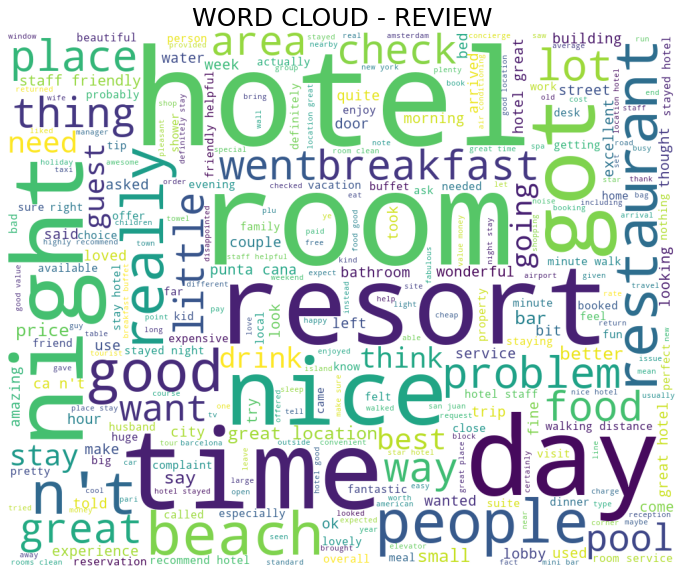

In [7]:

from wordcloud import WordCloud, STOPWORDS

stopwordsUpdated = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwordsUpdated,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(data['review'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - REVIEW",fontsize=25)
plt.axis('off')
plt.show()

# Distribution of the Ratings

In [8]:
fig = px.histogram(data['rating'],
                   labels={'value': 'Rating',
                           'count': 'Frequency',
                           'color': 'Rating'}, color=data['rating'])
fig.update_layout(bargap=0.2)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Ratings',
                  title_x=0.5, title_font=dict(size=20))
fig.show()

# The 200 Most Frequest Words

In [9]:
mostUsedWords = data['review'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]

fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='The 200 Most Frequest Words',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

# Data Preprocessing

In [10]:
# Transforming all texts to lowercase
data['review'] = data['review'].str.lower()
data['review'].head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms not 4* experience hotel monaco seat...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: review, dtype: object

In [11]:
# Removing Punctuations and Numbers from the Text
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


data['review'] = data['review'].apply(remove_punctuations_numbers)

# Tokenizing with NLTK

**Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning.   

**The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).****

In [12]:
def tokenization(inputs):  # Ref.1
    return word_tokenize(inputs)


data['text_tokenized'] = data['review'].apply(tokenization)
data['text_tokenized'].head()

0    [nice, hotel, expensive, parking, got, good, d...
1    [ok, nothing, special, charge, diamond, member...
2    [nice, rooms, not, experience, hotel, monaco, ...
3    [unique, great, stay, wonderful, time, hotel, ...
4    [great, stay, great, stay, went, seahawk, game...
Name: text_tokenized, dtype: object

# Stopwords Removal

"Stop word removal is one of the most commonly used preprocessing steps across different NLP applications. The idea is simply removing the words that occur commonly across all the documents in the corpus. Typically, articles and pronouns are generally classified as stop words. These words have no significance in some of the NLP tasks like information retrieval and classification, which means these words are not very discriminative. On the contrary, in some NLP applications stop word removal will have very little impact." - O'Reilly

In [13]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def stopwords_remove(inputs):  # Ref.2
    return [k for k in inputs if k not in stop_words]


data['text_stop'] = data['text_tokenized'].apply(stopwords_remove)
data['text_stop'].head()

0    [nice, hotel, expensive, parking, got, good, d...
1    [ok, nothing, special, charge, diamond, member...
2    [nice, rooms, not, experience, hotel, monaco, ...
3    [unique, great, stay, wonderful, time, hotel, ...
4    [great, stay, great, stay, went, seahawk, game...
Name: text_stop, dtype: object

# Lemmatization

Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning.

In [14]:
lemmatizer = WordNetLemmatizer()


def lemmatization(inputs):  # Ref.1
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]


data['text_lemmatized'] = data['text_stop'].apply(lemmatization)
data['text_lemmatized'].head()

0    [nice, hotel, expensive, park, get, good, deal...
1    [ok, nothing, special, charge, diamond, member...
2    [nice, room, not, experience, hotel, monaco, s...
3    [unique, great, stay, wonderful, time, hotel, ...
4    [great, stay, great, stay, go, seahawk, game, ...
Name: text_lemmatized, dtype: object

In [15]:
# Removing Words less than length 2
def remove_less_than_2(inputs):  # Ref.1
    return [j for j in inputs if len(j) > 2]


data['final'] = data['text_lemmatized'].apply(remove_less_than_2)

In [16]:
# Joining Tokens into Sentences
data['final'] = data['final'].str.join(' ')
data['final'].head()

0    nice hotel expensive park get good deal stay h...
1    nothing special charge diamond member hilton d...
2    nice room not experience hotel monaco seattle ...
3    unique great stay wonderful time hotel monaco ...
4    great stay great stay seahawk game awesome dow...
Name: final, dtype: object

# Most 200 Used Words the Dataset (Post Cleaning)¶


In [17]:
mostUsedWords = data['final'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]

fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='Most 200 Used Words the Dataset (Post Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

Based on the Treemap above, all of the words are unique words and there are no stopwords in this set. Most words are 'hotel', 'room' and 'room'. Due to the fact that we are dealing with a trip advisor hotel review dataset, it make sense

# Adding a new column that will be used for the prediction

I decided to create a new column which will be categorized as **recommended (1)** and **not recommended (0)** which will be used to predict whether a review will have a positive rating and if it will be recommended

In [18]:
recommended = []
for row in data['rating']:
    if row <= 1:    recommended.append(0)
    elif row == 2:   recommended.append(0)
    elif row == 3:  recommended.append(0)
    elif row == 4:  recommended.append(1)
    elif row == 5:  recommended.append(1)
    
    else:           recommended.append(0)

In [19]:
data['recommended'] = recommended
data.head()

,review,rating,text_tokenized,text_stop,text_lemmatized,final,recommended
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, park, get, good, deal...",nice hotel expensive park get good deal stay h...,1
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",nothing special charge diamond member hilton d...,0
2,nice rooms not experience hotel monaco seat...,3,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, rooms, not, experience, hotel, monaco, ...","[nice, room, not, experience, hotel, monaco, s...",nice room not experience hotel monaco seattle ...,0
3,unique great stay wonderful time hotel monac...,5,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game aweso...,5,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, go, seahawk, game, ...",great stay great stay seahawk game awesome dow...,1


# Distribution of the Recommendations

In [20]:
labels = ['Recommended', 'Not Recommended']
values = [data[data['recommended'] == 1]['recommended'].value_counts()[1],
          data[data['recommended'] == 0]['recommended'].value_counts()[0]]
colors = ['green', 'red']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, opacity=0.8)])
fig.update_traces(textinfo='percent+label', marker=dict(line=dict(color='#000000', width=2), colors=colors))
fig.update_layout(title_text='Distribution of the Recommendations', title_x=0.5, title_font=dict(size=20))
fig.show()

# Train-Test-Validation Split

In [21]:
# I will only use Text data to predict Recommendation
y = data['recommended']
X = data['final']

X.head()

0    nice hotel expensive park get good deal stay h...
1    nothing special charge diamond member hilton d...
2    nice room not experience hotel monaco seattle ...
3    unique great stay wonderful time hotel monaco ...
4    great stay great stay seahawk game awesome dow...
Name: final, dtype: object

In [22]:
# Train-Test-Validation Split
x, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=13)  # Test: %20

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=13)  # Val: %20

print('Shape of the X_train:', X_train.shape)
print('Shape of the X_test:', X_test.shape)
print('Shape of the X_val:', X_val.shape)
print('--'*20)
print('Shape of the y_train:', y_train.shape)
print('Shape of the y_test:', y_test.shape)
print('Shape of the y_val:', y_val.shape)

Shape of the X_train: (12294,)
Shape of the X_test: (4099,)
Shape of the X_val: (4098,)
----------------------------------------
Shape of the y_train: (12294,)
Shape of the y_test: (4099,)
Shape of the y_val: (4098,)


# Tokenizing with Tensorflow

In [23]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_val = tokenizer.texts_to_sequences(X_val)

print('Non-tokenized Version: ', X_train[0])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[0]]))
print('--'*20)
print('Non-tokenized Version: ', X_train[80])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[80]]))

Non-tokenized Version:  nice hotel expensive park get good deal stay hotel anniversary arrive late even take advice previous review valet park check quick easy little disappoint non existent view room room clean nice size bed comfortable wake stiff neck high pillow not soundproof like hear music room night morning loud bang doors open close hear people talk hallway maybe noisy neighbor aveda bath products nice not goldfish stay nice touch take advantage stay longer location great walk distance shop overall nice experience pay park night
Tokenized Version:  [[10, 2, 180, 96, 23, 7, 198, 5, 2, 745, 89, 231, 158, 56, 662, 490, 60, 644, 96, 34, 380, 163, 38, 210, 390, 2646, 37, 3, 3, 13, 10, 135, 25, 66, 668, 4448, 5169, 190, 384, 4, 2294, 20, 189, 403, 3, 17, 103, 543, 1737, 506, 111, 83, 189, 32, 441, 1319, 423, 354, 1616, 2426, 253, 1257, 10, 4, 5575, 5, 10, 336, 56, 956, 5, 788, 11, 6, 15, 197, 75, 120, 10, 84, 72, 96, 17]]
----------------------------------------
Non-tokenized Version

# Padding the Datasets

In [24]:
maxlen = 50
Padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
Padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

# Artificial Neural Network Model Creation

In [25]:
# Creating the Model
model = Sequential()

model.add(Embedding(num_words, 16, input_length=maxlen))
model.add(Dropout(0.2))

model.add(GlobalAvgPool1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(lr=0.55e-3)  # Learning Rate

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
dropout (Dropout)            (None, 50, 16)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


2022-11-26 11:19:12.974209: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [26]:
# Training the Model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,
                                                  restore_best_weights=True)

epochs = 100
hist = model.fit(Padded_train, y_train, epochs=epochs,
                 validation_data=(Padded_val, y_val),
                 callbacks=[early_stopping], batch_size=32)

2022-11-26 11:19:13.220430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
385/385 [==============================] - 3s 5ms/step - loss: 0.6245 - accuracy: 0.7326 - val_loss: 0.5634 - val_accuracy: 0.7396
Epoch 2/100
385/385 [==============================] - 1s 3ms/step - loss: 0.5414 - accuracy: 0.7372 - val_loss: 0.5184 - val_accuracy: 0.7396
Epoch 3/100
385/385 [==============================] - 1s 3ms/step - loss: 0.5063 - accuracy: 0.7379 - val_loss: 0.4868 - val_accuracy: 0.7438
Epoch 4/100
385/385 [==============================] - 1s 3ms/step - loss: 0.4725 - accuracy: 0.7535 - val_loss: 0.4541 - val_accuracy: 0.7699
Epoch 5/100
385/385 [==============================] - 1s 3ms/step - loss: 0.4359 - accuracy: 0.7883 - val_loss: 0.4227 - val_accuracy: 0.8075
Epoch 6/100
385/385 [==============================] - 1s 3ms/step - loss: 0.4048 - accuracy: 0.8221 - val_loss: 0.3969 - val_accuracy: 0.8309
Epoch 7/100
385/385 [==============================] - 1s 3ms/step - loss: 0.3756 - accuracy: 0.8431 - val_loss: 0.3773 - val_accuracy: 0.8441

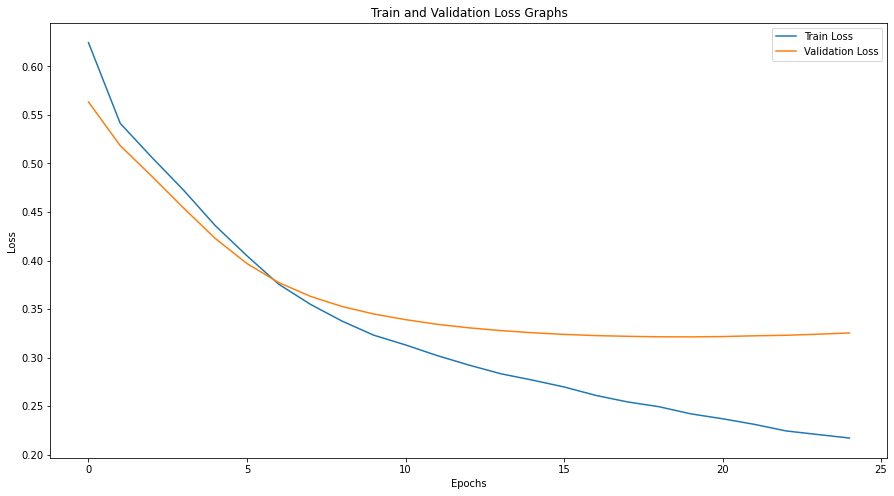

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Train and Validation Accuracy Graphs

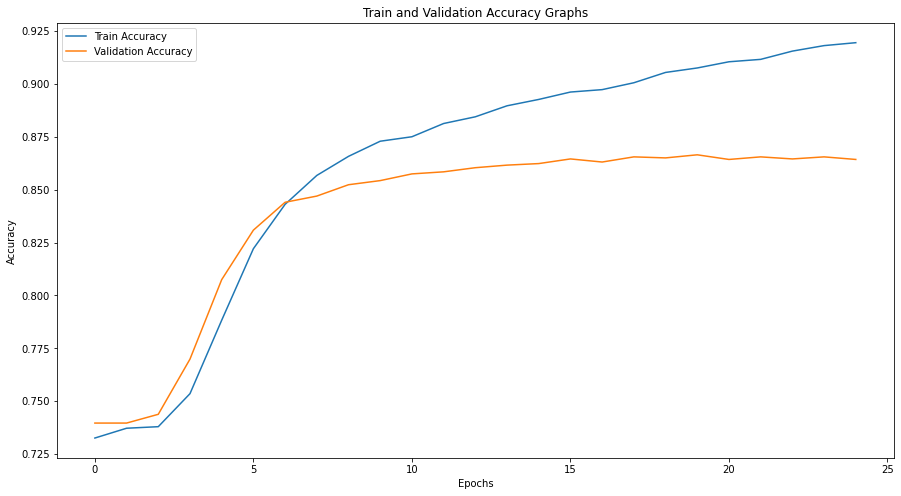

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Preparing the Test Data

In [29]:
X_test = X_test.apply(tokenization)
X_test = X_test.apply(stopwords_remove)
X_test = X_test.apply(lemmatization)
X_test = X_test.str.join(' ')

X_test.head()

3421     hole wall great cruise princess want relax san...
2743     nothing talk start let start help need check w...
10106    ideal position stay catalunya plaza nights ide...
17768    best hotel partner stay dream resort punta can...
13594    decent hotel poor location price good room far...
Name: final, dtype: object

In [30]:
Tokenized_test = tokenizer.texts_to_sequences(X_test)
Padded_test = pad_sequences(Tokenized_test, maxlen=maxlen, padding='pre')

test_evaluate = model.evaluate(Padded_test, y_test)

129/129 [==============================] - 0s 992us/step - loss: 0.3153 - accuracy: 0.8666


# Confusion Matrix of the Test Data¶

In [31]:
pred_train_lstm = model.predict(Padded_train)
pred_test_lstm = model.predict(Padded_test)

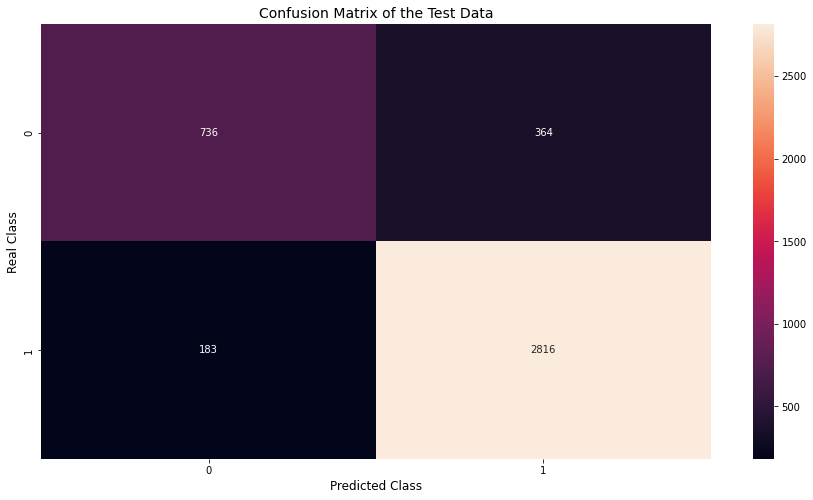

In [32]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm):
    if 0 <= x < 0.49:
        pred_train_lstm[i] = 0
    else:
        pred_train_lstm[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

# Evaluation Metrics of the LSTM Model¶

In [33]:
# Accuracy
train_acc_lstm = round(accuracy_score(y_train, pred_train_lstm) * 100, 2)
print('Train Accuracy of the LSTM: %', train_acc_lstm)
test_acc_lstm = round(accuracy_score(y_test, pred_test_lstm) * 100, 2)
print('Test Accuracy of the LSTM: %', test_acc_lstm)
print('--' * 20)

# Precision
train_precision_lstm = round(precision_score(y_train, pred_train_lstm, average='micro') * 100, 2)
print('Train Precision of the LSTM: %', train_precision_lstm)
precision_lstm = round(precision_score(y_test, pred_test_lstm, average='micro') * 100, 2)
print('Test Precision of the LSTM: %', precision_lstm)
print('--' * 20)

# Recall
train_recall_lstm = round(recall_score(y_train, pred_train_lstm,average='micro') * 100, 2)
print('Train Recall of the LSTM: %', train_recall_lstm)
recall_lstm = round(recall_score(y_test, pred_test_lstm, average='micro') * 100, 2)
print('Test Recall of the LSTM: %', recall_lstm)

Train Accuracy of the LSTM: % 91.2
Test Accuracy of the LSTM: % 86.66
----------------------------------------
Train Precision of the LSTM: % 91.2
Test Precision of the LSTM: % 86.66
----------------------------------------
Train Recall of the LSTM: % 91.2
Test Recall of the LSTM: % 86.66


In [34]:
def predict_recommendation(input_text):  # The function for doing all the previous steps
    input_text = input_text.lower()
    input_text = re.sub(r'[^a-zA-Z]', ' ', input_text)
    input_text = tokenization(input_text)
    input_text = stopwords_remove(input_text)
    input_text = lemmatization(input_text)
    input_text = ' '.join(input_text)
    input_text = tokenizer.texts_to_sequences([input_text])
    input_text = pad_sequences(input_text, maxlen=maxlen, padding='pre')
    input_text = model.predict(input_text)
    if input_text >= 0.5:
        input_text = f'Recommended (Good Rating) with %{round(float(input_text*100), 2)}'
    else:
        input_text = f'Not Recommended (Bad Rating) with %{round(float(input_text*100), 2)}'

    return print(input_text)

In [35]:
# This reviews above are taken from several websites for testing the model with real world data. You can find these websites in the Ref.5
predict_recommendation("Light, hip touches abound throughout the hotel, but beneath it all is a socially conscious theme that, unlikely as it sounds, affects your stay in interesting and enjoyable ways.")


Recommended (Good Rating) with %84.33


In [36]:
predict_recommendation("Worst hotel ive stayed in. - The lock housing was exposed meaning it wasnt difficult to break into our room. - No safety deposit boxes in rooms. - Hot water constantly running out. - No ventilation in bathroom (No window or extractor fan) leaving the bathroom misty after taking a shower and leaving it smelly after using the loo")

Not Recommended (Bad Rating) with %4.49


In [37]:
predict_recommendation("What a lovely surprise. We've never booked a holiday like this before but we're hooked and will definitely be back for more. Margarita is a family run establishment with a peaceful and tranquil atmosphere. Bar and restaurant is open early and closes late , the full English is excellent to start any day lazing by the pool or some sight seeng although we've enjoyed being lazy. Apartments are simple with clean and comfortable surroundings and the views are spectacular and the hospitality is wonderful, nothing is too much.")

Recommended (Good Rating) with %99.61


In [38]:
predict_recommendation("Rarely do I return to the same place, but this place is definitely worth more than one visit. Booked for a week in July 2016, ended up looking for a cheap flight back and staying 10 days")

Recommended (Good Rating) with %80.17


In [39]:
predict_recommendation("would leave zero stars if I could. The food is mediocre for the price and to make it even worse it is not even close to authentic. The breakfast ends at 10 30 but 09 30 everything finished for example milk finished etc..")

Not Recommended (Bad Rating) with %33.12


**I would appreciate your feedback & comments in order to improve not only my knowledge but future work**

# References

1. https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch02s07.html#:~:text=Stop%20word%20removal%20is%20one,generally%20classified%20as%20stop%20words.
2. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html#:~:text=Lemmatization%20usually%20refers%20to%20doing,is%20known%20as%20the%20lemma%20.
3.https://www.tripadvisor.com/ShowUserReviews-g1191686-d1226035-r486085561-Margarita_Apartments-Ipsos_Corfu_Ionian_Islands.html
4. https://intellipaat.com/blog/what-is-lstm/#:~:text='%20LSTM%20stands%20for%20long%20short,especially%20in%20sequence%20prediction%20problems.
5. https://www.geeksforgeeks.org/implementing-neural-networks-using-tensorflow/